## Day 8: Photometric Transformations and Filtering

#### Goals

* Understand how images are represented as arrays
* Know how to perform basic photometric transformations (brightness, thresholding)
* Understand image noise and why we need filtering
* Know how to filter an image using cross-correlation
* Know how to handle image borders when filtering
* Get a feel for operations possible with linear filtering (blur, sharpen)

In [61]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

# Library imports
import numpy as np
import matplotlib.pyplot as plt
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Image Representation

* Computationally: `ndarray` of size `(height, width, 3)`
* Mathematically: a function mapping **position** to **intensity** (or color)
    * Grayscale image: $f: \mathbb{R}^2 \Rightarrow \mathbb{R}$
    * Color image: $f: \mathbb{R}^2 \Rightarrow \mathbb{R^3}$

Shape: (600, 600, 3)
Dtype: uint8
Range: 0 to 255


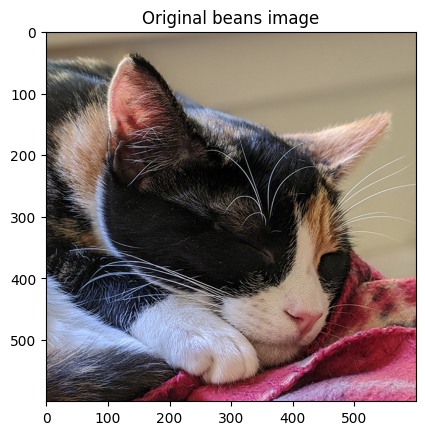

In [62]:
# Load image using OpenCV (loads as BGR by default)
beans_bgr = cv2.imread("../data/beans.jpg")
# Convert BGR to RGB for display with matplotlib
beans = cv2.cvtColor(beans_bgr, cv2.COLOR_BGR2RGB)

print(f"Shape: {beans.shape}")
print(f"Dtype: {beans.dtype}")
print(f"Range: {beans.min()} to {beans.max()}")
plt.imshow(beans)
plt.title("Original beans image")
plt.show()

**Important conventions:** 

1. Most standard images (jpg, png, etc) are stored with 8-bit (1-byte) values for R, G, and B.

2. **OpenCV loads images in BGR order** (not RGB!), so we typically convert to RGB for display with matplotlib: `cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`

3. If we want to do math to an image, we will get quantization error with integer types.

4. Standard move: convert from integer types (0 - 255) to floating point

5. The standard convention for the valid (displayable) **range** of floating-point values is 0 (darkest) to 1 (lightest).

Dtype: float32
Range: 0.0 to 1.0


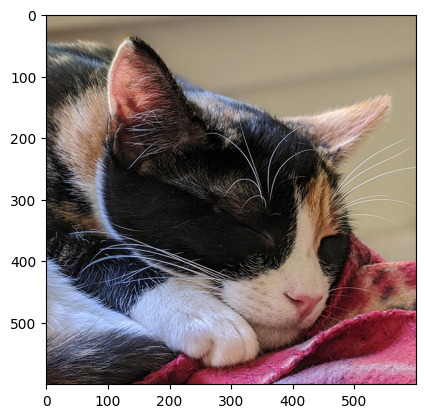

In [63]:
# Convert to float in range [0, 1]
beans = beans.astype(np.float32) / 255.0
print(f"Dtype: {beans.dtype}")
print(f"Range: {beans.min()} to {beans.max()}")

# matplotlib obeys these dtype/range conventions:
# if it sees bytes, it assumes 0-255
# if it sees floats, it assumes 0-1 range
plt.imshow(beans)
plt.show()

## Part 1: Photometric Transformations

**Photometric transformations** - operations that modify intensity values.

Suppose $g(x, y) = f(x, y) + 0.2$

or in code:
```python
g = beans + 0.2
```

How will $g$ compare to $f$?

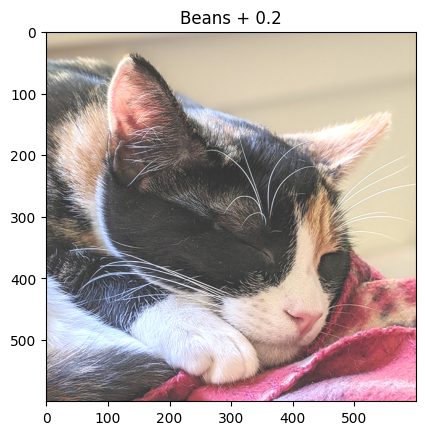

In [64]:
g = beans + 0.2
plt.imshow(g.clip(0, 1))
plt.title("Beans + 0.2")
plt.show()

### Brightness (scaling)

$$ g(x, y) = s \cdot f(x, y)$$

where $s$ is a scale factor.

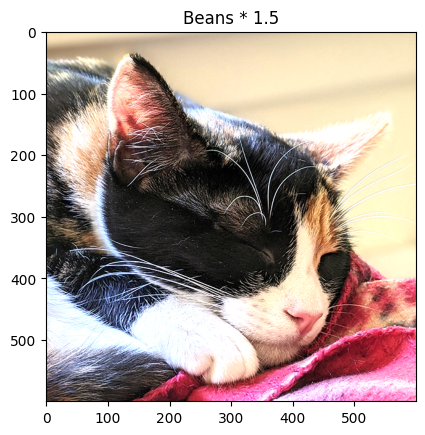

In [65]:
s = 1.5
g = beans * s
plt.imshow(g.clip(0, 1))
plt.title(f"Beans * {s}")
plt.show()

### Thresholding

$$
h(x, y) = 
\begin{cases}
0 & \text{if } f(x, y) < t\\
1 & \text{if } f(x, y) \ge t
\end{cases}
$$

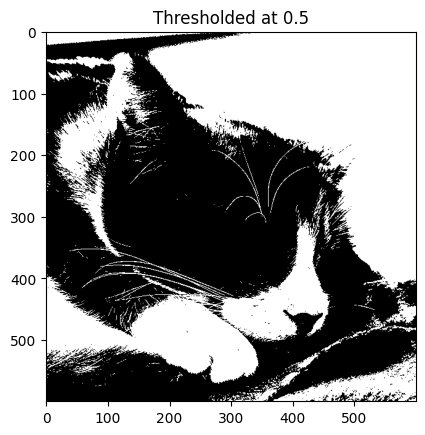

In [66]:
# Convert to grayscale using OpenCV
beans_gray = cv2.cvtColor(beans, cv2.COLOR_RGB2GRAY)
thresh = 0.5

# Simple thresholding
g = (beans_gray >= thresh).astype(np.float32)

plt.imshow(g, cmap="gray")
plt.title(f"Thresholded at {thresh}")
plt.show()

## Part 2: Image Filtering

### Motivation: Image Noise

How do we record light intensity inside a camera?
* Film (has grain)
* Digital sensors (have noise)

Let's add some noise to our image:

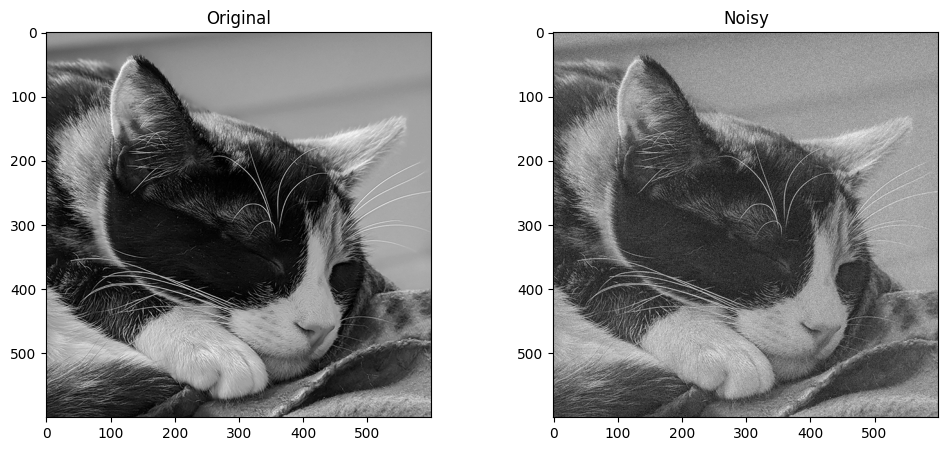

In [67]:
# Create a noisy version
# Convert to grayscale using OpenCV
bg = cv2.cvtColor(beans, cv2.COLOR_RGB2GRAY)
bn = bg + np.random.randn(*bg.shape) * 0.05

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(bg, cmap="gray")
axes[0].set_title("Original")
axes[1].imshow(bn, cmap="gray")
axes[1].set_title("Noisy")
plt.show()

### Question: How can we reduce noise?

If each pixel measurement is corrupted, how can we improve our guess at what the "ideal" image should have been?

**Idea:** Use information from neighboring pixels!

### Mean Filter

Replace each pixel with the average of its neighbors in a window.

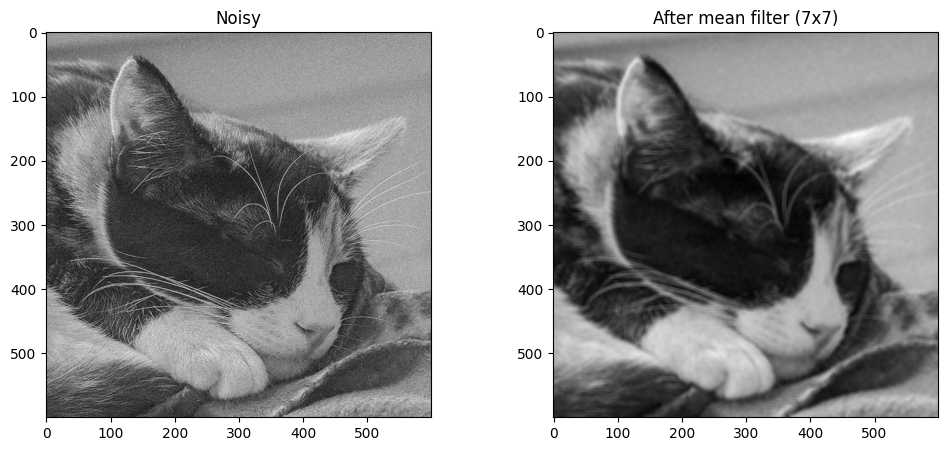

In [68]:
# Pseudocode for mean filter:
#
# def mean_filter(img, filter_size):
#     l = filter_size // 2  # half-width of the filter
#     output = np.zeros_like(img)
#     for r in range(l, height - l):
#         for c in range(l, width - l):
#             window = img[r-l:r+l+1, c-l:c+l+1]
#             output[r, c] = window.mean()
#     return output

# Using OpenCV's blur (mean filter)
denoised = cv2.blur(bn, ksize=(7, 7))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(bn, cmap="gray")
axes[0].set_title("Noisy")
axes[1].imshow(denoised, cmap="gray")
axes[1].set_title("After mean filter (7x7)")
plt.show()

We can do better than averaging over little boxes

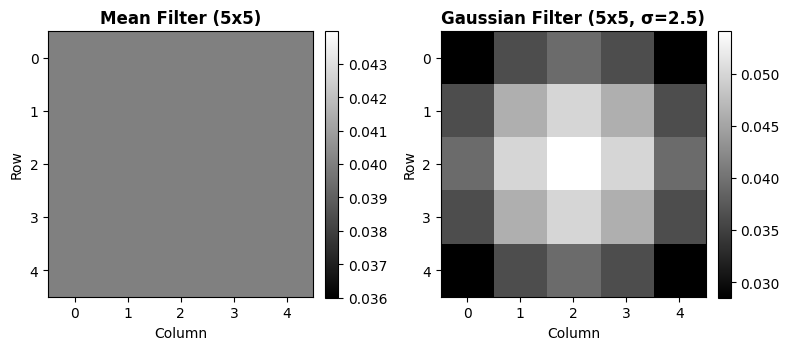

In [69]:
# Create two 5x5 filters
# 1. Mean filter (uniform weights)
mean_kernel = np.ones((5, 5), dtype=np.float32) / 25

# 2. Gaussian filter
# Create 1D Gaussian kernel and compute outer product for 2D
gauss_1d = cv2.getGaussianKernel(5, sigma=2.5)
gauss_kernel = gauss_1d @ gauss_1d.T

# Apply both filters to the noisy image
mean_result = cv2.filter2D(bn, -1, mean_kernel)
gauss_result = cv2.filter2D(bn, -1, gauss_kernel)

# Create a 2x2 visualization
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Top row: filter kernels
im0 = axes[0].imshow(mean_kernel, cmap='gray', interpolation='nearest')
axes[0].set_title('Mean Filter (5x5)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Row')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(gauss_kernel, cmap='gray', interpolation='nearest')
axes[1].set_title('Gaussian Filter (5x5, σ=2.5)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)


plt.tight_layout()
plt.show()

But how do we apply the second filter?

### Idea: general filters are weighted averages

Instead of a uniform mean (every pixel in the window is equally weighted) we can use different **weights** for different neighbors. The matrix of weights is called a **filter**.

Applying a filter at each pixel in an image produces a new **filtered image**. Properly speaking, the operation of filtering an image is called **Cross Correlation**, and we use the symbol $\otimes$:

### Cross-Correlation

Given an image $f$ and a filter (or kernel) $w$:

$$
(f \otimes w)(x, y) = \sum_{j=-\ell}^\ell \sum_{k=-\ell}^\ell f(x+j, y+k) \cdot w(j, k)
$$

In words: For each pixel, compute a weighted sum of the neighborhood.

*Fine print: writing cross correlation this way implies that the filter indices run from $-l, ... l$. That's a mathematically convenient way to think about it. But in practice filters are matrices. Matrices are indexed from $0, ..., 2l$. So the code will have some index shifts.*

### Edge Handling

What happens when the filter window hangs over the edge of the image? 

**Options for output size:**
* **valid** - only output where the whole filter overlaps the image
* **same** - output same size as input (most common, default in OpenCV)
* **full** - output everywhere the filter touches the image (very weird, not used)

**Options for handling out-of-bounds values:**
* **Zero padding** - treat out-of-bounds as 0 (`cv2.BORDER_CONSTANT`)
* **Repeat/replicate** - repeat edge values (`cv2.BORDER_REPLICATE`)
* **Reflect** - mirror the image at the boundary (`cv2.BORDER_REFLECT` or `cv2.BORDER_REFLECT_101`)

**OpenCV's cv2.filter2D():**
* `-1` as second argument means output has same dtype as input
* `borderType` parameter controls edge handling

[OpenCV docs](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga209f2f4869e304c82d07739337eae7c5)

### Filtering in OpenCV

OpenCV doesn't have a cross-correlation function. Why?

Cross correlation isn't commutative. That is, $f \otimes g \neq g \otimes f$. But with a very small tweak we can have a commutative operation. Consider these two definitions:

$$
(f \otimes w)(x, y) = \sum_{j=-\ell}^\ell \sum_{k=-\ell}^\ell f(x+j, y+k) \cdot w(j, k)
$$


$$
(f * w)(x, y) = \sum_{j=-\ell}^\ell \sum_{k=-\ell}^\ell f(x+j, y+k) \cdot w(j, k)
$$

The second operation is called convolution. It's equivalent to flipping the first input up/down and left/right and then doing cross-correlation. 

In OpenCV, use `cv2.filter2D` to convolve an image with a filter. You can convolve $f * g$ or $g * f$ -- it's commutative, so they are the same.

